# East Asia, South Asia and Pacific Clustering

The code of the DIANA algorithm is from Github and changed to fit this data. 

## Dataframe Gender

In [1]:
!pip install scikit-learn-extra

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score

In [3]:
df = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Data')

In [4]:
df = df.iloc[54000:,]
df.drop(columns=df.iloc[:,3:54].columns.tolist(), inplace=True)
df.rename({'Indicator Name':'Indicator'},inplace=True,axis=1)
df.rename({'Country Name':'Country'},inplace=True,axis=1)
df = df.loc[df.Indicator.str.contains('1=yes; 0=no')]
df = df.assign(Mean_GV=df.mean(axis=1, numeric_only=True))
df.drop(columns=df.iloc[:,3:16].columns.tolist(), inplace=True)
del df['Country Code']
df = pd.pivot(df, index=['Country'], columns = 'Indicator',values = 'Mean_GV')

In [5]:
importances = np.array([0.01831044, 0.03237455, 0.0031967 , 0.012108  , 0.01552896,
       0.00758614, 0.00181886, 0.0546642 , 0.01587967, 0.01247531,
       0.02007783, 0.0364012 , 0.03424009, 0.03465867, 0.02593966,
       0.01570586, 0.05781482, 0.01149065, 0.00752398, 0.05290953,
       0.07132007, 0.01305223, 0.03959353, 0.04099451, 0.02862905,
       0.00649011, 0.00942123, 0.00436768, 0.03333931, 0.02942839,
       0.02490152, 0.02989014, 0.0245622 , 0.05561928, 0.11768564])

In [6]:
df.iloc[:,] *= importances
df = df.assign(Gender_Var=df.sum(axis=1, numeric_only=True))
df.dropna(axis=0, inplace = True)
df.drop(columns=df.iloc[:,0:35].columns.tolist(), inplace=True)

## Dataframe Gini

In [7]:
df1 = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Data')

In [8]:
df1 = df1.iloc[54000:,]
df1.drop(columns=df1.iloc[:,3:54].columns.tolist(), inplace=True)
df1.rename({'Indicator Name':'Indicator'},inplace=True,axis=1)
df1.rename({'Country Name':'Country'},inplace=True,axis=1)
df1 = df1.loc[df1.Indicator.str.contains('Gini index')]
df1 = df1.assign(Gini_Var=df1.mean(axis=1, numeric_only=True))
df1.drop(columns=df1.iloc[:,1:16].columns.tolist(), inplace=True)
df1.dropna(axis=0, inplace = True)

## Dataframe Growth

In [9]:
df2 = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Data')

In [10]:
df2 = df2.iloc[54000:,]
df2.drop(columns=df2.iloc[:,3:54].columns.tolist(), inplace=True)
df2.rename({'Indicator Name':'Indicator'},inplace=True,axis=1)
df2.rename({'Country Name':'Country'},inplace=True,axis=1)
df2 = df2.loc[df2.Indicator.str.contains('GDP growth')]
df2 = df2.assign(Growth_Var=df2.mean(axis=1, numeric_only=True))
df2.drop(columns=df2.iloc[:,1:16].columns.tolist(), inplace=True)
df2.dropna(axis=0, inplace = True)

## Dataframe continents

In [11]:
df_Continent = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Country')

In [12]:
print(df_Continent['Region'].unique())

['Latin America & Caribbean' nan 'South Asia' 'Sub-Saharan Africa'
 'Europe & Central Asia' 'Middle East & North Africa'
 'East Asia & Pacific' 'North America']


In [13]:
df_Continent = df_Continent[['Table Name', 'Region']]
df_Continent.rename({'Table Name':'Country'},inplace=True,axis=1)
df_Continent.dropna(axis=0, inplace = True)

## Dataframe Gender-Growth

In [15]:
df_Gender_Growth = df.merge(df2,how='inner',left_on='Country', right_on='Country')
df_Gender_Growth = df_Gender_Growth.merge(df_Continent, how='inner',left_on='Country', right_on='Country')
df_Gender_Growth.head()

,Country,Gender_Var,Growth_Var,Region
0,Afghanistan,0.187844,2.019799,South Asia
1,Albania,0.750623,2.576940,Europe & Central Asia
2,Algeria,0.470927,2.108333,Middle East & North Africa
3,Angola,0.559647,1.527807,Sub-Saharan Africa
4,Antigua and Barbuda,0.473140,0.504912,Latin America & Caribbean


## Dataframe Gini-Growth

In [16]:
df_Gini_Growth = df1.merge(df2,how='inner',left_on='Country', right_on='Country')
df_Gini_Growth = df_Gini_Growth.merge(df_Continent, how='inner',left_on='Country', right_on='Country')
df_Gini_Growth.head()

,Country,Gini_Var,Growth_Var,Region
0,Albania,32.014286,2.576940,Europe & Central Asia
1,Algeria,27.600000,2.108333,Middle East & North Africa
2,Angola,51.300000,1.527807,Sub-Saharan Africa
3,Argentina,41.960000,1.191811,Latin America & Caribbean
4,Armenia,30.827273,3.600000,Europe & Central Asia


## Filter on East Asia and Pacific

In [17]:
df_Gender_Growth_EA = df_Gender_Growth.loc[df_Gender_Growth['Region'].isin(['East Asia & Pacific','South Asia'])]
df_Gini_Growth_EA = df_Gini_Growth.loc[df_Gini_Growth['Region'].isin(['East Asia & Pacific','South Asia'])]

In [19]:
df_Gender_Growth_EA.shape

(36, 4)

In [20]:
df_Gini_Growth_EA.shape

(30, 4)

In [27]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

## Gender-Growth Variable

### K-means clustering

In [58]:
df_Gender_Growth_EA_K = df_Gender_Growth_EA[['Gender_Var', 'Growth_Var']]

In [59]:
sse_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gender_Growth_EA_K)
    sse_.append([k, silhouette_score(df_Gender_Growth_EA_K, kmeans.labels_)])
sse_

[[2, 0.6299499098718779],
 [3, 0.5735544212542508],
 [4, 0.6218760142442384],
 [5, 0.6364172436412874],
 [6, 0.5716438001862905],
 [7, 0.5682599426023194],
 [8, 0.4970607430809298],
 [9, 0.4972651787235099]]

In [60]:
DB_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gender_Growth_EA_K)
    DB_.append([k, davies_bouldin_score(df_Gender_Growth_EA_K, kmeans.labels_)])
DB_

[[2, 0.5087488126928124],
 [3, 0.488256323569102],
 [4, 0.4613609407735867],
 [5, 0.4006238701735055],
 [6, 0.46050891691444923],
 [7, 0.5087055873719115],
 [8, 0.5605936223310921],
 [9, 0.5712757110817415]]

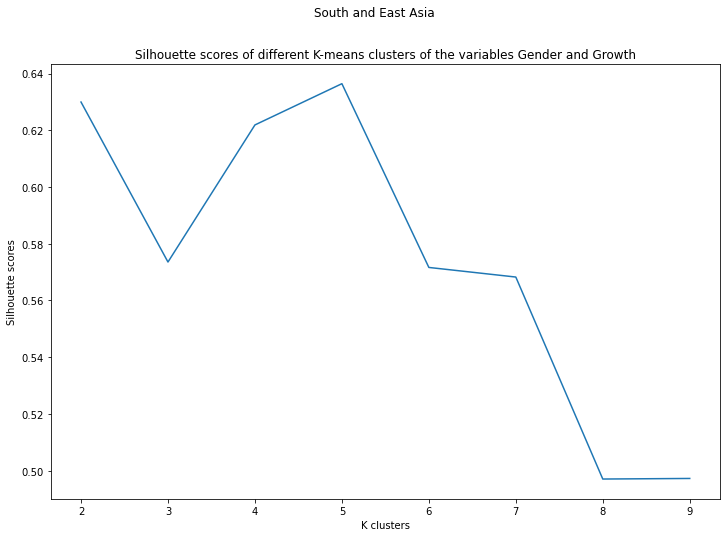

In [61]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-means clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("South and East Asia")
plt.show()

In [62]:
model_clus1 = KMeans(n_clusters = 5, random_state = 42)
model_clus1.fit(df_Gender_Growth_EA_K)
data1 = df_Gender_Growth_EA_K
data1.index = pd.RangeIndex(len(data1.index))
df_Gender_Growth_EA_K = pd.concat([data1, pd.Series(model_clus1.labels_)], axis = 1)
df_Gender_Growth_EA_K.columns = ['Gender_Var', 'Growth_Var', 'ClusterID_K']
df_Gender_Growth_EA_K['ClusterID_K'].value_counts()

0    11
3    10
1     7
2     6
4     2
Name: ClusterID_K, dtype: int64

In [63]:
 df_Gender_Growth_EA = pd.merge(df_Gender_Growth_EA,  df_Gender_Growth_EA_K, how = 'inner', left_on=['Gender_Var', 'Growth_Var'], right_on=['Gender_Var', 'Growth_Var'])

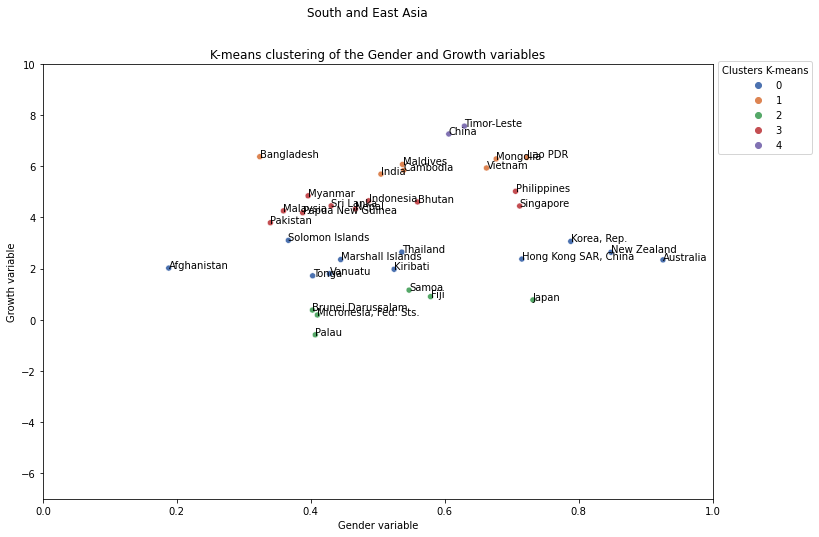

In [64]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_K', legend = 'full', palette="deep", data = df_Gender_Growth_EA)
plt.title('K-means clustering of the Gender and Growth variables')
plt.suptitle("South and East Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
plt.xlim([0,1])
plt.ylim([-7,10])
label_point(df_Gender_Growth_EA.Gender_Var, df_Gender_Growth_EA.Growth_Var, df_Gender_Growth_EA.Country, plt.gca()) 
plt.legend(title='Clusters K-means', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [65]:
Cluster_Gender = pd.DataFrame(df_Gender_Growth_EA.groupby(['ClusterID_K']).Gender_Var.mean())
Cluster_Growth = pd.DataFrame(df_Gender_Growth_EA.groupby(['ClusterID_K']).Growth_Var.mean())
dt_EA_knn_Gender_Growth = pd.concat([Cluster_Gender, Cluster_Growth], axis = 1)
dt_EA_knn_Gender_Growth

,Gender_Var,Growth_Var
ClusterID_K,,
0,0.560710,2.365402
1,0.566608,6.078976
2,0.512741,0.468124
3,0.484311,4.457683
4,0.617767,7.415264


### K-medoids clustering

In [66]:
df_Gender_Growth_EA_KM = df_Gender_Growth_EA[['Gender_Var', 'Growth_Var']]

In [67]:
sse_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, method = 'pam', random_state = 42).fit(df_Gender_Growth_EA_KM)
    sse_.append([k, silhouette_score(df_Gender_Growth_EA_KM, kmedoids.labels_)])
sse_

[[2, 0.6299499098718779],
 [3, 0.5865657292691393],
 [4, 0.6218760142442384],
 [5, 0.5555588514553063],
 [6, 0.5716438001862905],
 [7, 0.5828928216845625],
 [8, 0.5598933692606303],
 [9, 0.4972651787235099]]

In [68]:
DB_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, random_state = 42).fit(df_Gender_Growth_EA_KM)
    DB_.append([k, davies_bouldin_score(df_Gender_Growth_EA_KM, kmedoids.labels_)])
DB_

[[2, 0.5151907101557157],
 [3, 0.488256323569102],
 [4, 0.4613609407735867],
 [5, 0.5697628515676953],
 [6, 0.5871537929627386],
 [7, 0.6621310302186002],
 [8, 0.6199046279901363],
 [9, 0.5418663549960647]]

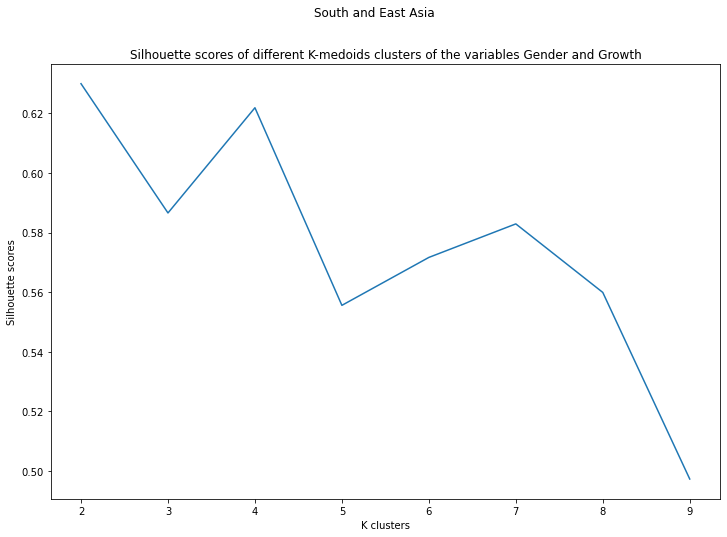

In [69]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-medoids clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("South and East Asia")
plt.show()

In [70]:
model_clus2 = KMedoids(n_clusters = 4, random_state = 42, method = 'pam')
model_clus2.fit(df_Gender_Growth_EA_KM)
data2 = df_Gender_Growth_EA_KM
data2.index = pd.RangeIndex(len(data2.index))
df_Gender_Growth_EA_KM = pd.concat([data2, pd.Series(model_clus2.labels_)], axis = 1)
df_Gender_Growth_EA_KM.columns = ['Gender_Var', 'Growth_Var', 'ClusterID_KM']
df_Gender_Growth_EA_KM['ClusterID_KM'].value_counts()

1    11
2    10
3     9
0     6
Name: ClusterID_KM, dtype: int64

In [71]:
df_Gender_Growth_EA = pd.merge(df_Gender_Growth_EA, df_Gender_Growth_EA_KM, how = 'inner', left_on=['Gender_Var', 'Growth_Var'], right_on=['Gender_Var', 'Growth_Var'])

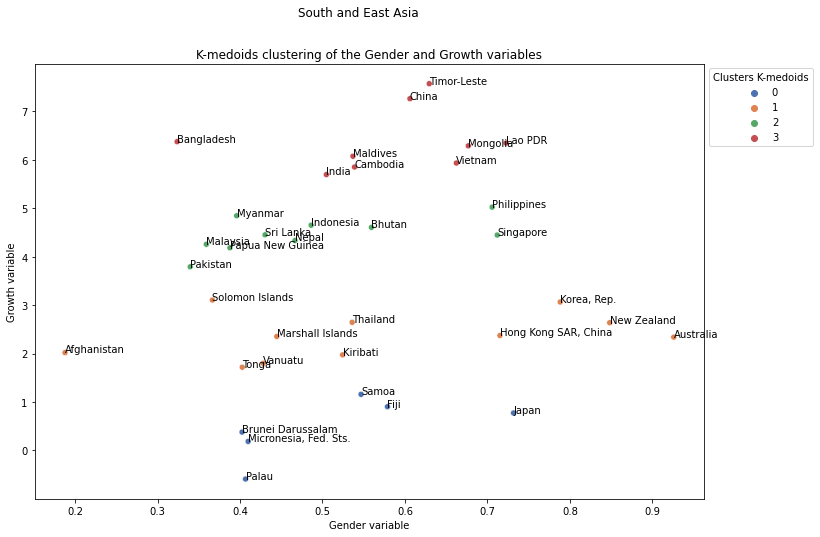

In [72]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_KM', legend = 'full', palette="deep", data = df_Gender_Growth_EA)
plt.title('K-medoids clustering of the Gender and Growth variables')
plt.suptitle("South and East Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_EA.Gender_Var, df_Gender_Growth_EA.Growth_Var, df_Gender_Growth_EA.Country, plt.gca()) 
plt.legend(title='Clusters K-medoids', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [73]:
Cluster_Gender = pd.DataFrame(df_Gender_Growth_EA_KM.groupby(['ClusterID_KM']).Gender_Var.mean())
Cluster_Growth = pd.DataFrame(df_Gender_Growth_EA_KM.groupby(['ClusterID_KM']).Growth_Var.mean())
dt_EA_km_Gender_Growth = pd.concat([Cluster_Gender, Cluster_Growth], axis = 1)
dt_EA_km_Gender_Growth

,Gender_Var,Growth_Var
ClusterID_KM,,
0,0.512741,0.468124
1,0.560710,2.365402
2,0.484311,4.457683
3,0.577977,6.375929


### AGNES clustering

In [74]:
df_Gender_Growth_EA_A = df_Gender_Growth_EA[['Gender_Var', 'Growth_Var']]

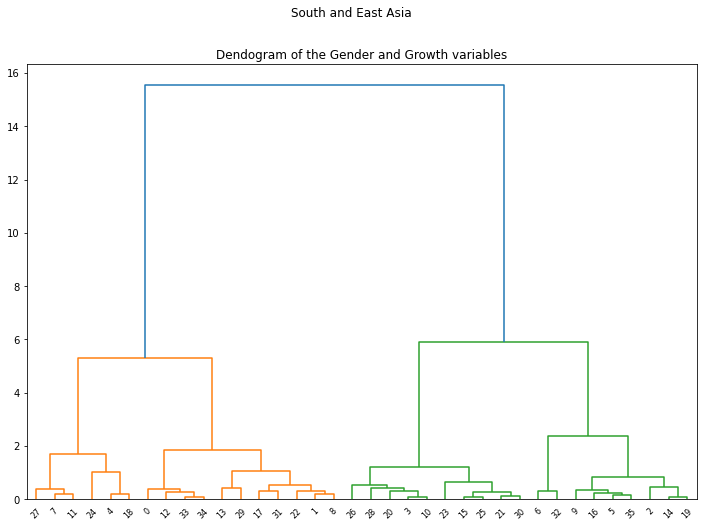

In [75]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gender and Growth variables')
plt.suptitle("South and East Asia")
dend = shc.dendrogram(shc.linkage(df_Gender_Growth_EA_A, method = 'ward'))

In [76]:
sse_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gender_Growth_EA_A)
    silhouette_average = silhouette_score(df_Gender_Growth_EA_A, cluster_labels)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.6299499098718779],
 [3, 0.5865657292691393],
 [4, 0.6218760142442384],
 [5, 0.6364172436412874],
 [6, 0.5719612678943004],
 [7, 0.5828928216845625],
 [8, 0.5009863114923888],
 [9, 0.4962094675949533]]

In [77]:
DB_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gender_Growth_EA_A)
    davies_bouldin = davies_bouldin_score(df_Gender_Growth_EA_A, cluster_labels)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.5087488126928124],
 [3, 0.42946990814712044],
 [4, 0.4613609407735867],
 [5, 0.4006238701735055],
 [6, 0.4478694617725874],
 [7, 0.4776043901091603],
 [8, 0.5576931389532427],
 [9, 0.5772274474005665]]

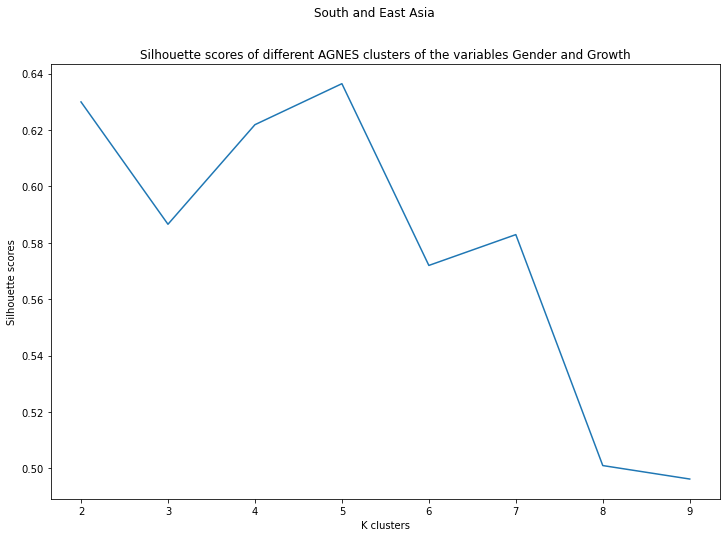

In [78]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different AGNES clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("South and East Asia")
plt.show()

In [79]:
cluster = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean' ,linkage = 'ward')
ClusterID_A = cluster.fit_predict(df_Gender_Growth_EA_A)
ClusterID_A

array([0, 0, 3, 2, 1, 3, 4, 1, 0, 3, 2, 1, 0, 0, 3, 2, 3, 0, 1, 3, 2, 2,
       0, 2, 1, 2, 2, 1, 2, 0, 2, 0, 4, 0, 0, 3])

In [80]:
df_Gender_Growth_EA['ClusterID_A'] = [0, 0, 3, 2, 1, 3, 4, 1, 0, 3, 2, 1, 0, 0, 3, 2, 3, 0, 1, 3, 2, 2,
       0, 2, 1, 2, 2, 1, 2, 0, 2, 0, 4, 0, 0, 3]

In [81]:
df_Gender_Growth_EA['ClusterID_A'].value_counts()

0    11
2    10
3     7
1     6
4     2
Name: ClusterID_A, dtype: int64

In [82]:
df_Gender_Growth_EA.head()

,Country,Gender_Var,Growth_Var,Region,ClusterID_K,ClusterID_KM,ClusterID_A
0,Afghanistan,0.187844,2.019799,South Asia,0,1,0
1,Australia,0.925931,2.338581,East Asia & Pacific,0,1,0
2,Bangladesh,0.323755,6.373057,South Asia,1,3,3
3,Bhutan,0.559430,4.604392,South Asia,3,2,2
4,Brunei Darussalam,0.402492,0.378767,East Asia & Pacific,2,0,1


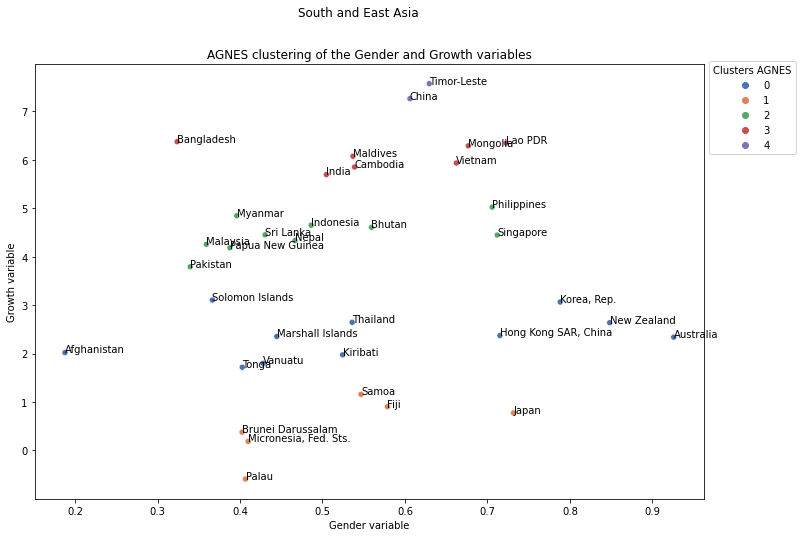

In [83]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_A', legend = 'full', palette="deep", data = df_Gender_Growth_EA)
plt.title('AGNES clustering of the Gender and Growth variables')
plt.suptitle("South and East Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_EA.Gender_Var, df_Gender_Growth_EA.Growth_Var, df_Gender_Growth_EA.Country, plt.gca()) 
plt.legend(title='Clusters AGNES', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

### DIANA clustering

In [84]:
df_Gender_Growth_EA_D = df_Gender_Growth_EA[['Gender_Var', 'Growth_Var']]

In [85]:
from scipy.spatial import distance_matrix

def DIANA(data, n_clusters):
    n_samples = len(data)
    n_features = 2
    similarity_matrix = distance_matrix(data.values, data.values) # similarity matrix of the data
    clusters = [list(range(n_samples))]      # list of clusters, initially the whole dataset is a single cluster
    while True:
        c_diameters = [np.max(similarity_matrix[cluster][:, cluster]) for cluster in clusters]  #cluster diameters
        max_cluster_dia = np.argmax(c_diameters)  #maximum cluster diameter
        max_difference_index = np.argmax(np.mean(similarity_matrix[clusters[max_cluster_dia]][:, clusters[max_cluster_dia]], axis=1))
        splinters = [clusters[max_cluster_dia][max_difference_index]] #spinter group
        last_clusters = clusters[max_cluster_dia]
        del last_clusters[max_difference_index]
        while True:
            split = False
            for j in range(len(last_clusters))[::-1]:
                splinter_distances = similarity_matrix[last_clusters[j], splinters]
                last_distances = similarity_matrix[last_clusters[j], np.delete(last_clusters, j, axis=0)]
                if np.mean(splinter_distances) <= np.mean(last_distances):
                    splinters.append(last_clusters[j])
                    del last_clusters[j]
                    split = True
                    break
            if split == False:
                break
        del clusters[max_cluster_dia]
        clusters.append(splinters)
        clusters.append(last_clusters)
        if len(clusters) == n_clusters:
            break

    cluster_labels = np.zeros(n_samples)
    for i in range(len(clusters)):
        cluster_labels[clusters[i]] = i

    return cluster_labels

In [86]:
sse_ = []
for k in range (2,10):
    clustering = DIANA(df_Gender_Growth_EA_D, k)
    silhouette_average = silhouette_score(df_Gender_Growth_EA_D, clustering)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.6299499098718779],
 [3, 0.5865657292691393],
 [4, 0.6218760142442384],
 [5, 0.6364172436412874],
 [6, 0.598492029382286],
 [7, 0.5355944993536815],
 [8, 0.46322743357770935],
 [9, 0.4808284391235331]]

In [87]:
DB_ = []
for k in range (2,10):
    clustering = DIANA(df_Gender_Growth_EA_D, k)
    davies_bouldin = davies_bouldin_score(df_Gender_Growth_EA_D, clustering)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.5087488126928124],
 [3, 0.42946990814712044],
 [4, 0.4613609407735867],
 [5, 0.4006238701735055],
 [6, 0.3713668792600095],
 [7, 0.47328264654428637],
 [8, 0.5513642814553619],
 [9, 0.5078521645729327]]

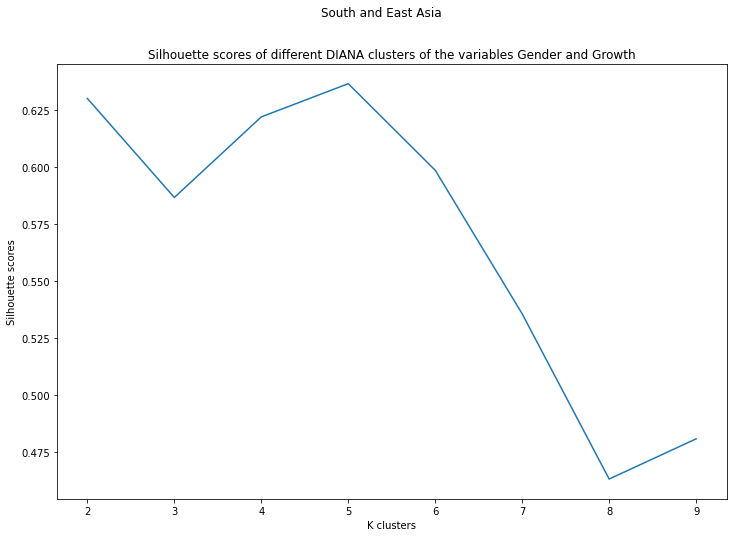

In [88]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different DIANA clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("South and East Asia")
plt.show()

In [89]:
DIANA(df_Gender_Growth_EA_D, 5)

array([2., 2., 4., 0., 1., 4., 3., 1., 2., 4., 0., 1., 2., 2., 4., 0., 4.,
       2., 1., 4., 0., 0., 2., 0., 1., 0., 0., 1., 0., 2., 0., 2., 3., 2.,
       2., 4.])

In [90]:
df_Gender_Growth_EA['ClusterID_D'] = [round(float(i)) for i in [2., 2., 4., 0., 1., 4., 3., 1., 2., 4., 0., 1., 2., 2., 4., 0., 4.,
       2., 1., 4., 0., 0., 2., 0., 1., 0., 0., 1., 0., 2., 0., 2., 3., 2.,
       2., 4.]]

In [91]:
df_Gender_Growth_EA['ClusterID_D'].value_counts()

2    11
0    10
4     7
1     6
3     2
Name: ClusterID_D, dtype: int64

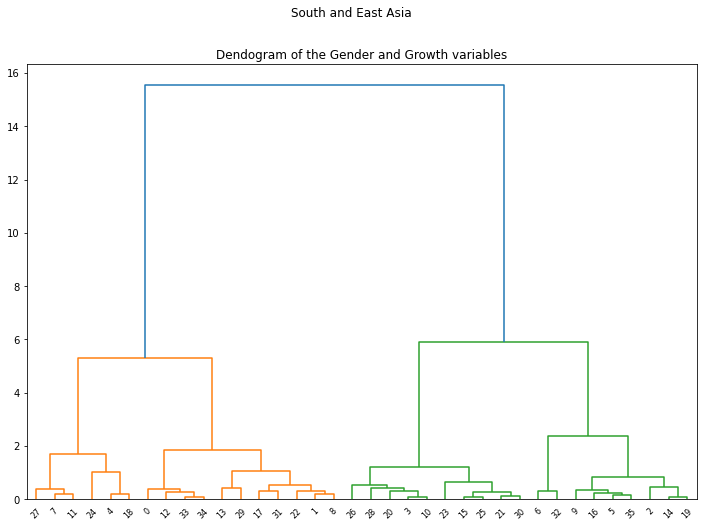

In [92]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gender and Growth variables')
plt.suptitle("South and East Asia")
dend = shc.dendrogram(shc.linkage(df_Gender_Growth_EA_D, method = 'ward'))

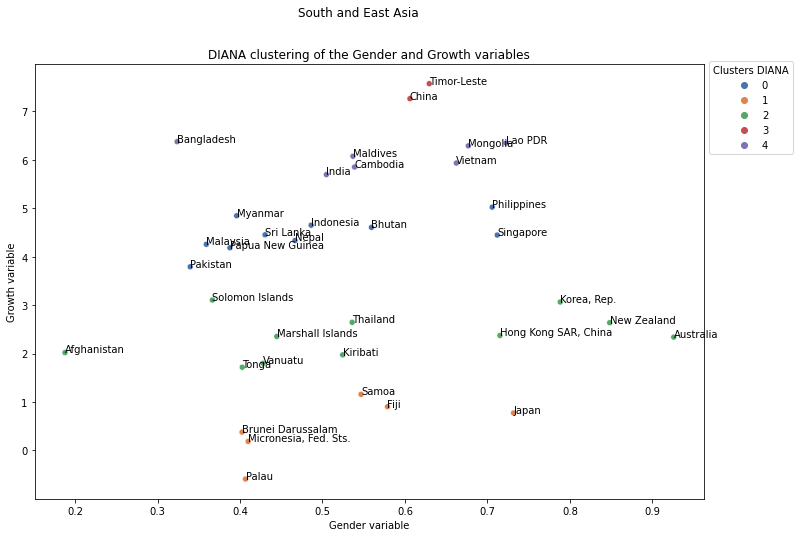

In [93]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_D', legend = 'full', palette="deep", data = df_Gender_Growth_EA)
plt.title('DIANA clustering of the Gender and Growth variables')
plt.suptitle("South and East Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_EA.Gender_Var, df_Gender_Growth_EA.Growth_Var, df_Gender_Growth_EA.Country, plt.gca()) 
plt.legend(title='Clusters DIANA', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

## Growth-Gini Variable

### K-means clustering

In [95]:
df_Gini_Growth_EA_K = df_Gini_Growth_EA[['Growth_Var', 'Gini_Var']]

In [96]:
sse_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gini_Growth_EA_K)
    sse_.append([k, silhouette_score(df_Gini_Growth_EA_K, kmeans.labels_)])
sse_

[[2, 0.40048839762123484],
 [3, 0.28808395062096986],
 [4, 0.34223994617684156],
 [5, 0.34385935271303664],
 [6, 0.37656073126343553],
 [7, 0.36640323362739513],
 [8, 0.38064416980288124],
 [9, 0.3645058070208629]]

In [97]:
DB_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gini_Growth_EA_K)
    DB_.append([k, davies_bouldin_score(df_Gini_Growth_EA_K, kmeans.labels_)])
DB_

[[2, 0.8589854611276349],
 [3, 1.0463535437147693],
 [4, 0.8503930140740725],
 [5, 0.8479629029651999],
 [6, 0.7453888614684875],
 [7, 0.8007818209619391],
 [8, 0.7223258348937538],
 [9, 0.6631762944640677]]

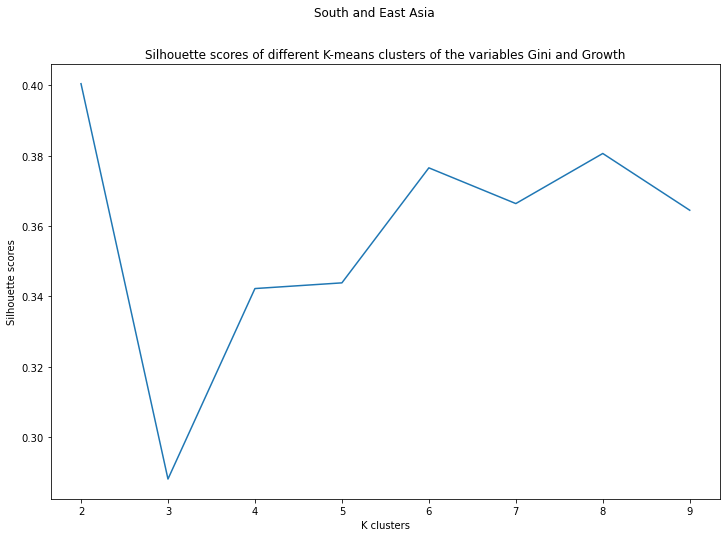

In [98]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-means clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("South and East Asia")
plt.show()

In [99]:
model_clus1 = KMeans(n_clusters = 8, random_state = 42)
model_clus1.fit(df_Gini_Growth_EA_K)
data1 = df_Gini_Growth_EA_K
data1.index = pd.RangeIndex(len(data1.index))
df_Gini_Growth_EA_K = pd.concat([data1, pd.Series(model_clus1.labels_)], axis = 1)
df_Gini_Growth_EA_K.columns = ['Growth_Var', 'Gini_Var', 'ClusterID_K']
df_Gini_Growth_EA_K['ClusterID_K'].value_counts()

5    5
0    5
3    5
1    4
7    4
2    3
4    2
6    2
Name: ClusterID_K, dtype: int64

In [100]:
df_Gini_Growth_EA = pd.merge(df_Gini_Growth_EA,  df_Gini_Growth_EA_K, how = 'inner', left_on=['Growth_Var', 'Gini_Var'], right_on=['Growth_Var', 'Gini_Var'])

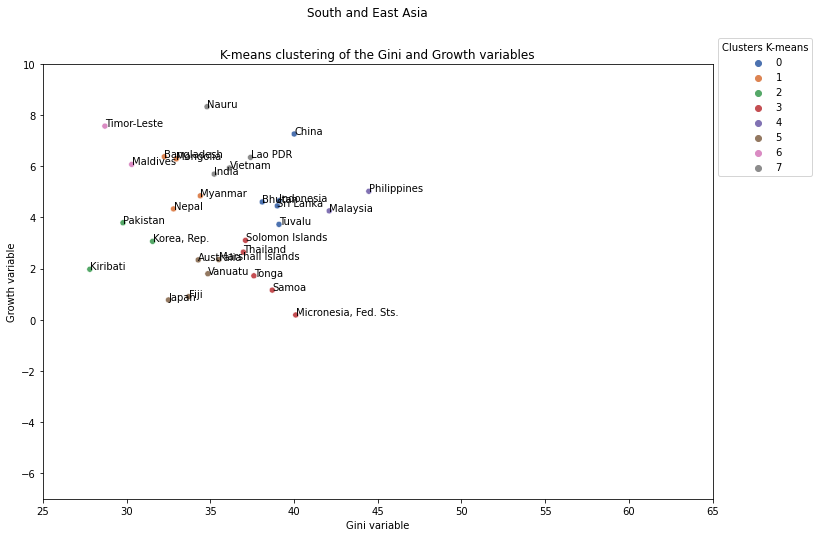

In [101]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_K', legend = 'full', palette="deep", data = df_Gini_Growth_EA)
plt.title('K-means clustering of the Gini and Growth variables')
plt.suptitle("South and East Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_EA.Gini_Var, df_Gini_Growth_EA.Growth_Var, df_Gini_Growth_EA.Country, plt.gca()) 
plt.xlim([25,65])
plt.ylim([-7,10])
plt.legend(title='Clusters K-means', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [102]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_EA.groupby(['ClusterID_K']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_EA.groupby(['ClusterID_K']).Gini_Var.mean())
dt_EA_knn_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_EA_knn_Growth_Gini

,Growth_Var,Gini_Var
ClusterID_K,,
0,4.938450,39.062000
1,5.459005,33.104167
2,2.942301,29.710000
3,1.761965,38.094545
4,4.638438,43.283333
5,1.632892,34.165000
6,6.820939,29.500000
7,6.574556,35.893333


### K-medoids clustering

In [103]:
df_Gini_Growth_EA_KM = df_Gini_Growth_EA[['Growth_Var', 'Gini_Var']]

In [104]:
sse_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, method = 'pam', random_state = 42).fit(df_Gini_Growth_EA_KM)
    sse_.append([k, silhouette_score(df_Gini_Growth_EA_KM, kmedoids.labels_)])
sse_

[[2, 0.40048839762123484],
 [3, 0.2923054686505315],
 [4, 0.3262586419408838],
 [5, 0.32685219331384957],
 [6, 0.3452067498444275],
 [7, 0.37204524143049017],
 [8, 0.3643434100562848],
 [9, 0.351468588098065]]

In [105]:
DB_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, random_state = 42).fit(df_Gini_Growth_EA_KM)
    DB_.append([k, davies_bouldin_score(df_Gini_Growth_EA_KM, kmedoids.labels_)])
DB_

[[2, 0.8589854611276349],
 [3, 0.9032286181770527],
 [4, 0.9447674345224841],
 [5, 0.873398431383651],
 [6, 0.9734266808132007],
 [7, 0.9744733478517748],
 [8, 0.8901131884977742],
 [9, 0.8423161377955628]]

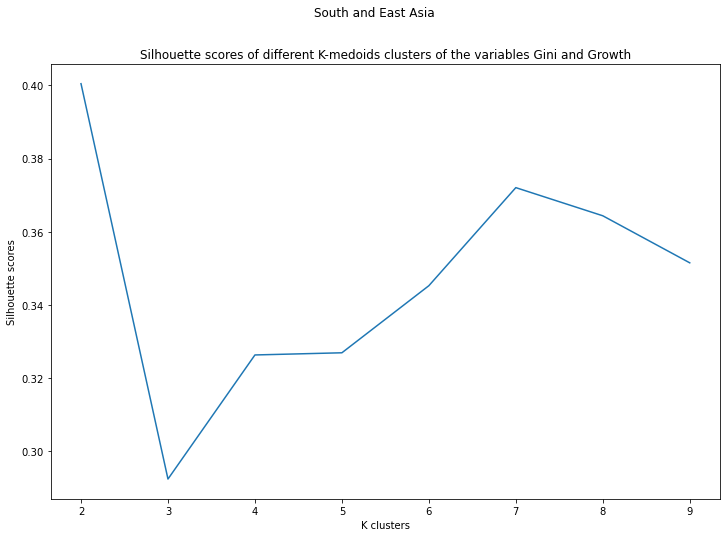

In [106]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-medoids clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("South and East Asia")
plt.show()

In [107]:
model_clus2 = KMedoids(n_clusters = 7, random_state = 42, method = 'pam')
model_clus2.fit(df_Gini_Growth_EA_KM)
data2 = df_Gini_Growth_EA_KM
data2.index = pd.RangeIndex(len(data2.index))
df_Gini_Growth_EA_KM = pd.concat([data2, pd.Series(model_clus2.labels_)], axis = 1)
df_Gini_Growth_EA_KM.columns = ['Growth_Var', 'Gini_Var', 'ClusterID_KM']
df_Gini_Growth_EA_KM['ClusterID_KM'].value_counts()

6    5
4    5
3    5
1    5
2    5
5    3
0    2
Name: ClusterID_KM, dtype: int64

In [108]:
df_Gini_Growth_EA = pd.merge(df_Gini_Growth_EA, df_Gini_Growth_EA_KM, how = 'inner', left_on=['Growth_Var', 'Gini_Var'], right_on=['Growth_Var', 'Gini_Var'])

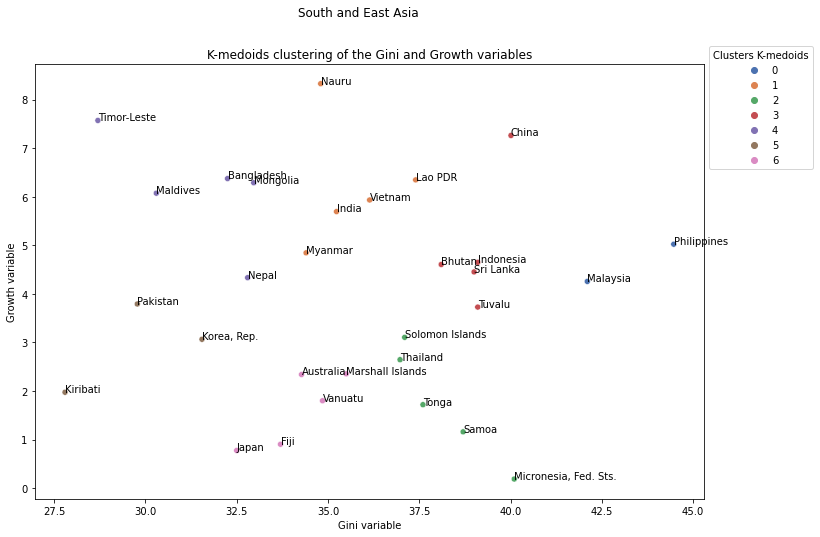

In [109]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_KM', legend = 'full', palette="deep", data = df_Gini_Growth_EA)
plt.title('K-medoids clustering of the Gini and Growth variables')
plt.suptitle("South and East Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_EA.Gini_Var, df_Gini_Growth_EA.Growth_Var, df_Gini_Growth_EA.Country, plt.gca()) 
plt.legend(title='Clusters K-medoids', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [110]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_EA.groupby(['ClusterID_KM']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_EA.groupby(['ClusterID_KM']).Gini_Var.mean())
dt_EA_km_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_EA_km_Growth_Gini

,Growth_Var,Gini_Var
ClusterID_KM,,
0,4.638438,43.283333
1,6.228392,35.594667
2,1.761965,38.094545
3,4.938450,39.062000
4,6.126833,31.403333
5,2.942301,29.710000
6,1.632892,34.165000


### AGNES algorithm

In [111]:
df_Gini_Growth_EA_A = df_Gini_Growth_EA[['Growth_Var', 'Gini_Var']]

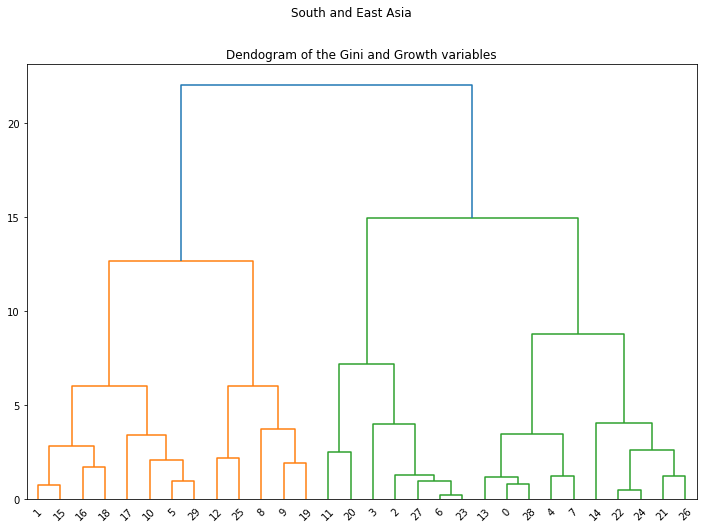

In [112]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gini and Growth variables')
plt.suptitle("South and East Asia")
dend = shc.dendrogram(shc.linkage(df_Gini_Growth_EA_A, method = 'ward'))

In [113]:
sse_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gini_Growth_EA_A)
    silhouette_average = silhouette_score(df_Gini_Growth_EA_A, cluster_labels)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.33255905436077793],
 [3, 0.31753212348996523],
 [4, 0.3468819564202787],
 [5, 0.3432193857015665],
 [6, 0.36180353300531914],
 [7, 0.3575877411160901],
 [8, 0.38064416980288124],
 [9, 0.3469282413320789]]

In [114]:
DB_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gini_Growth_EA_A)
    davies_bouldin = davies_bouldin_score(df_Gini_Growth_EA_A, cluster_labels)
    DB_.append([k, davies_bouldin])
DB_

[[2, 1.038831836750055],
 [3, 0.9423615474920494],
 [4, 0.8485990741978799],
 [5, 0.8333017642051503],
 [6, 0.727383884323875],
 [7, 0.6903527746813529],
 [8, 0.7223258348937538],
 [9, 0.6512615625903347]]

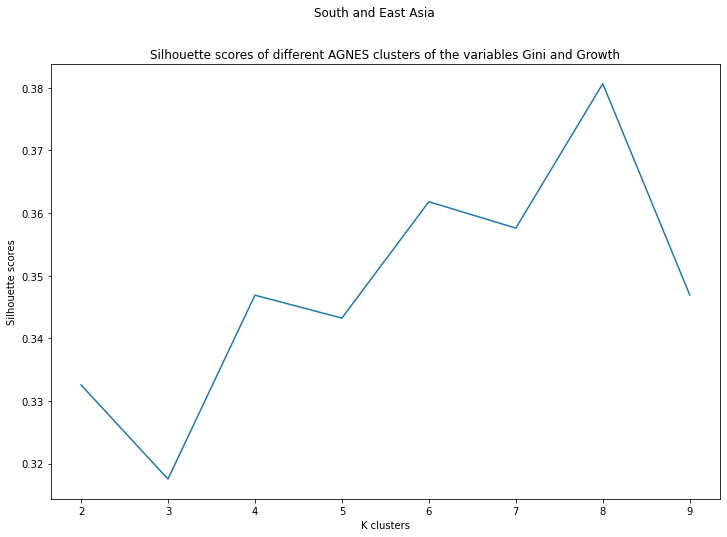

In [115]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different AGNES clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("South and East Asia")
plt.show()

In [116]:
cluster = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean' ,linkage = 'ward')
ClusterID_A = cluster.fit_predict(df_Gini_Growth_EA_A)
ClusterID_A

array([4, 7, 1, 1, 4, 2, 1, 4, 3, 3, 2, 5, 6, 4, 0, 7, 7, 2, 7, 3, 5, 0,
       0, 1, 0, 6, 0, 1, 4, 2])

In [117]:
df_Gini_Growth_EA['ClusterID_A'] = [4, 7, 1, 1, 4, 2, 1, 4, 3, 3, 2, 5, 6, 4, 0, 7, 7, 2, 7, 3, 5, 0,
       0, 1, 0, 6, 0, 1, 4, 2]

In [118]:
df_Gini_Growth_EA['ClusterID_A'].value_counts()

4    5
1    5
0    5
7    4
2    4
3    3
5    2
6    2
Name: ClusterID_A, dtype: int64

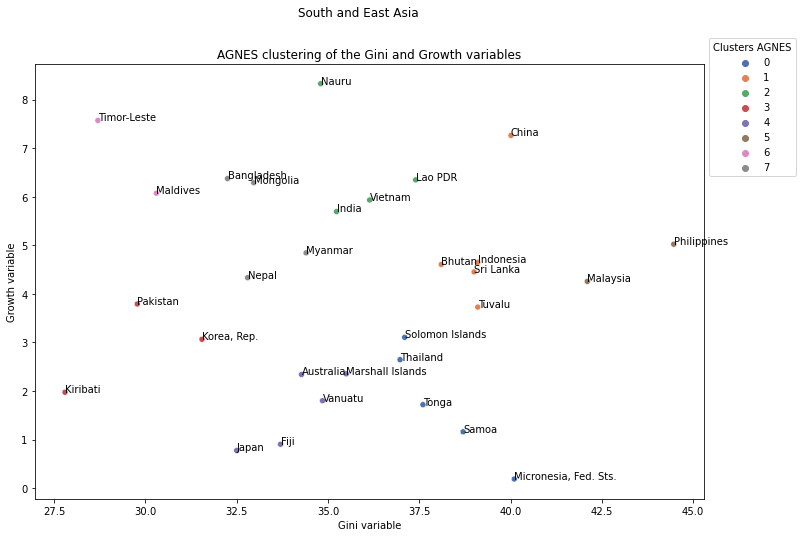

In [119]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_A', legend = 'full', palette="deep", data = df_Gini_Growth_EA)
plt.title('AGNES clustering of the Gini and Growth variables')
plt.suptitle("South and East Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_EA.Gini_Var, df_Gini_Growth_EA.Growth_Var, df_Gini_Growth_EA.Country, plt.gca()) 
plt.legend(title='Clusters AGNES', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

### DIANA clustering

In [120]:
df_Gini_Growth_EA_D = df_Gini_Growth_EA[['Growth_Var', 'Gini_Var']]

In [121]:
from scipy.spatial import distance_matrix

def DIANA(data, n_clusters):
    n_samples = len(data)
    n_features = 2
    similarity_matrix = distance_matrix(data.values, data.values) # similarity matrix of the data
    clusters = [list(range(n_samples))]      # list of clusters, initially the whole dataset is a single cluster
    while True:
        c_diameters = [np.max(similarity_matrix[cluster][:, cluster]) for cluster in clusters]  #cluster diameters
        max_cluster_dia = np.argmax(c_diameters)  #maximum cluster diameter
        max_difference_index = np.argmax(np.mean(similarity_matrix[clusters[max_cluster_dia]][:, clusters[max_cluster_dia]], axis=1))
        splinters = [clusters[max_cluster_dia][max_difference_index]] #spinter group
        last_clusters = clusters[max_cluster_dia]
        del last_clusters[max_difference_index]
        while True:
            split = False
            for j in range(len(last_clusters))[::-1]:
                splinter_distances = similarity_matrix[last_clusters[j], splinters]
                last_distances = similarity_matrix[last_clusters[j], np.delete(last_clusters, j, axis=0)]
                if np.mean(splinter_distances) <= np.mean(last_distances):
                    splinters.append(last_clusters[j])
                    del last_clusters[j]
                    split = True
                    break
            if split == False:
                break
        del clusters[max_cluster_dia]
        clusters.append(splinters)
        clusters.append(last_clusters)
        if len(clusters) == n_clusters:
            break

    cluster_labels = np.zeros(n_samples)
    for i in range(len(clusters)):
        cluster_labels[clusters[i]] = i

    return cluster_labels

In [122]:
sse_ = []
for k in range (2,10):
    clustering = DIANA(df_Gini_Growth_EA_D, k)
    silhouette_average = silhouette_score(df_Gini_Growth_EA_D, clustering)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.3870946562305842],
 [3, 0.315110119878743],
 [4, 0.26610898728215254],
 [5, 0.28205895971564837],
 [6, 0.2645773549269731],
 [7, 0.2688402585164156],
 [8, 0.2966745920796878],
 [9, 0.29496832975557946]]

In [123]:
DB_ = []
for k in range (2,10):
    clustering = DIANA(df_Gini_Growth_EA_D, k)
    davies_bouldin = davies_bouldin_score(df_Gini_Growth_EA_D, clustering)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.8881172748570515],
 [3, 0.8909033507981116],
 [4, 1.006468464408282],
 [5, 0.8070064533438028],
 [6, 0.8292727225369375],
 [7, 0.7707366998908426],
 [8, 0.7275523758238027],
 [9, 0.6440327313924591]]

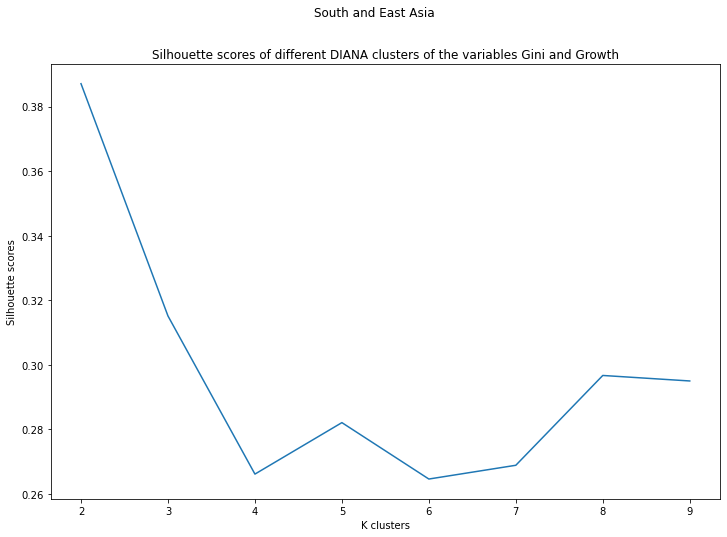

In [124]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different DIANA clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("South and East Asia")
plt.show()

In [125]:
DIANA(df_Gini_Growth_EA_D, 3)

array([0., 0., 2., 1., 0., 0., 2., 0., 0., 0., 2., 1., 0., 2., 2., 0., 0.,
       0., 0., 0., 1., 2., 2., 2., 2., 0., 2., 2., 2., 2.])

In [126]:
df_Gini_Growth_EA['ClusterID_D'] = [round(float(i)) for i in [0., 0., 2., 1., 0., 0., 2., 0., 0., 0., 2., 1., 0., 2., 2., 0., 0.,
       0., 0., 0., 1., 2., 2., 2., 2., 0., 2., 2., 2., 2.]]

In [127]:
df_Gini_Growth_EA['ClusterID_D'].value_counts()

0    14
2    13
1     3
Name: ClusterID_D, dtype: int64

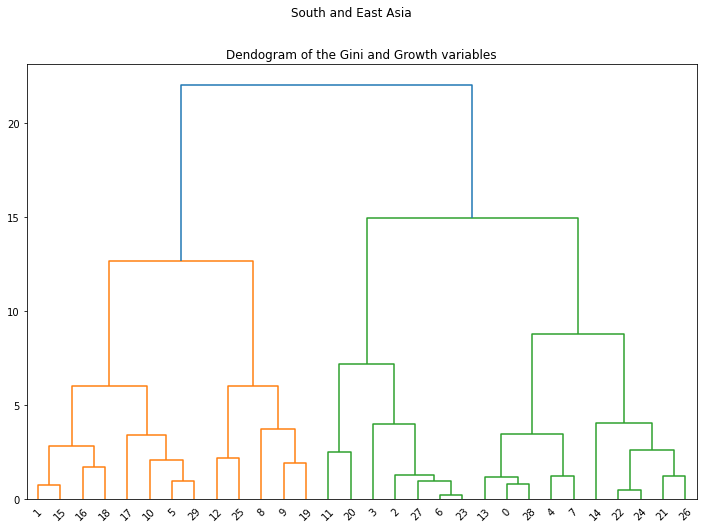

In [128]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gini and Growth variables')
plt.suptitle("South and East Asia")
dend = shc.dendrogram(shc.linkage(df_Gini_Growth_EA_D, method = 'ward'))

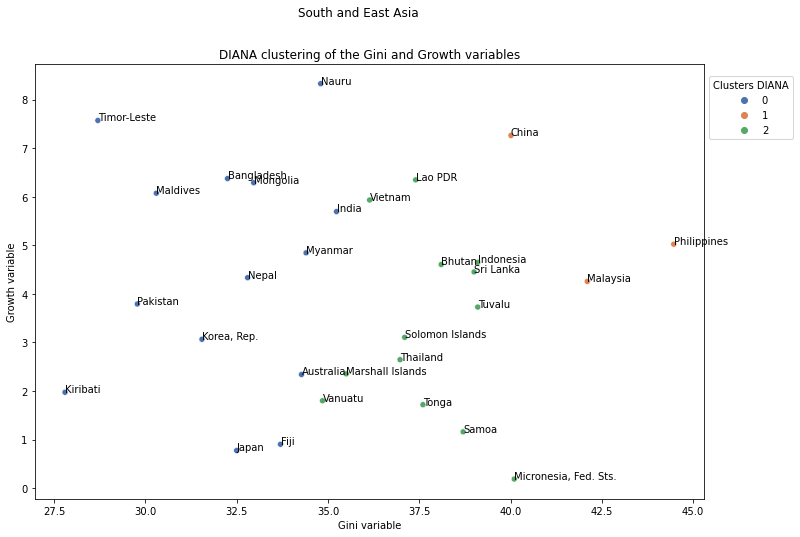

In [129]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_D', legend = 'full', palette="deep", data = df_Gini_Growth_EA)
plt.title('DIANA clustering of the Gini and Growth variables')
plt.suptitle("South and East Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_EA.Gini_Var, df_Gini_Growth_EA.Growth_Var, df_Gini_Growth_EA.Country, plt.gca()) 
plt.legend(title='Clusters DIANA', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()